# Выбор локации для скважины

Мы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**Импортируем необходимые библиотеки**

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy import stats as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint



**Создадим переменные-константы**

In [2]:
BUDGET = 10000000000
CHOSEN_POINTS = 500
BEST_POINTS = 200
PRICE_BARREL = 450000
BOOTSTRAP = 1000
INTERVAL = .95
RANDOM_STATE = np.random.RandomState(32123)

**Загрузим предоставленные датасеты**

In [3]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

**Создадим функцию для вывода информации о датафреймах**

In [4]:
def df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe(percentiles=[.5]).T)
    print(f"Количество дубликатов: {df.duplicated().sum()}")

**1.1 Просмотрим информацию о первом датасете**

In [5]:
df_info(df_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,50%,max
f0,100000.0,0.500419,0.871832,-1.408605,0.502360,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,0.250252,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,2.515969,16.003790
product,100000.0,92.500000,44.288691,0.000000,91.849972,185.364347


Количество дубликатов: 0


**Удалим столбец id, т.к. он не представляет пользы для модели**

In [6]:
df_0 = df_0.drop(['id'], axis=1)

**1.2 Просмотрим информацию о втором датасете**

In [7]:
df_info(df_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,50%,max
f0,100000.0,1.141296,8.965932,-31.609576,1.153055,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-4.813172,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,2.011479,5.019721
product,100000.0,68.825000,45.944423,0.000000,57.085625,137.945408


Количество дубликатов: 0


In [8]:
df_1 = df_1.drop(['id'], axis=1)

**1.3 Просмотрим информацию о третьем датасете**

In [9]:
df_info(df_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,50%,max
f0,100000.0,0.002023,1.732045,-8.760004,0.009424,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-0.009482,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,2.484236,16.739402
product,100000.0,95.000000,44.749921,0.000000,94.925613,190.029838


Количество дубликатов: 0


In [10]:
df_2 = df_2.drop(['id'], axis=1)

### Вывод:

1. Импортировали необходимые для работы библиотеки и загрузили предоставленные нам датасеты
2. Изучили датасеты методами head(), info() и describe()
3. Удалили столбец id в каждом датасете
4. Пропущенные значения отсутствуют

## Обучение и проверка модели

In [11]:
def train_linear_regression(data, feature_columns, target_column, test_size=0.25, random_state=42, n_iter=30, n_jobs=-1):

    # Разделение данных на признаки и целевую переменную
    features = data[feature_columns]
    target = data[target_column]
    
    # Разделение на тренировочную и валидационную выборки
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=test_size, random_state=random_state
    )
    
    # Визуализация распределения целевой переменной в обучающей выборке
    plt.figure(figsize=(12, 6))
    target_train.hist(bins=20)
    plt.suptitle('Распределение целевой переменной')
    plt.xlabel('Значение целевой переменной')
    plt.ylabel('Частота')
    plt.show()
    
    # Стандартизация признаков
    scaler = StandardScaler()
    scaler.fit(features_train)
    
    features_train = pd.DataFrame(
        scaler.transform(features_train),
        columns=features_train.columns,
        index=features_train.index
    )
    features_valid = pd.DataFrame(
        scaler.transform(features_valid),
        columns=features_valid.columns,
        index=features_valid.index
    )
    

    # Инициализация модели и RandomizedSearchCV
    lr_model = LinearRegression()
    
    # Обучение модели
    lr_model.fit(features_train, target_train)

    # Предсказание на валидационных данных
    predicted_valid = lr_model.predict(features_valid)
    
    # Вычисление RMSE
    rmse = mean_squared_error(target_valid, predicted_valid, squared=False)
    print(f"RMSE на валидационной выборке: {rmse}")
    
    # Среднее предсказанное значение
    predicted_mean = predicted_valid.mean()
    print(f"Среднее значение предсказания: {predicted_mean}")
    
    # Возвращение результатов
    return {
        'model': lr_model,
        'rmse': rmse,
        'predicted_mean': predicted_mean,
        'features_valid': features_valid,
        'features_train': features_train,
        'target_train': target_train,
        'target_valid': target_valid
    }

### Модель для первого региона

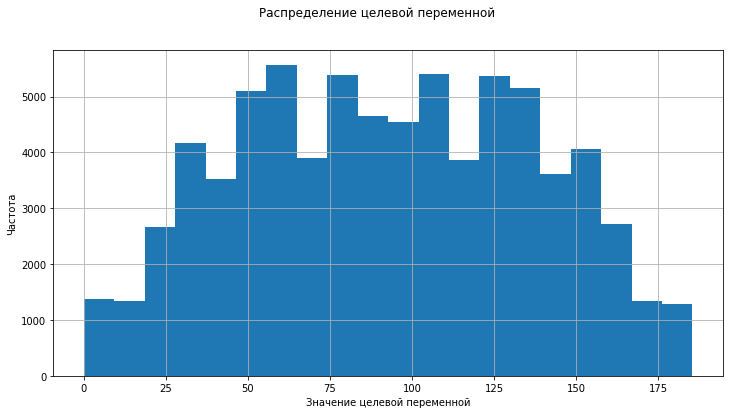

RMSE на валидационной выборке: 37.75660035026169
Среднее значение предсказания: 92.39879990657768


In [12]:
result_0 = train_linear_regression(
    data=df_0,
    feature_columns=['f0', 'f1', 'f2'],
    target_column='product',
    test_size=0.25,
    random_state=42,
    n_iter=30,
    n_jobs=-1
)


In [13]:
features_valid_0 = result_0.get('features_valid')
features_train_0 = result_0.get('features_train')
target_valid_0 = result_0.get('target_valid')
target_train_0 = result_0.get('target_train')

### Модель для второго региона

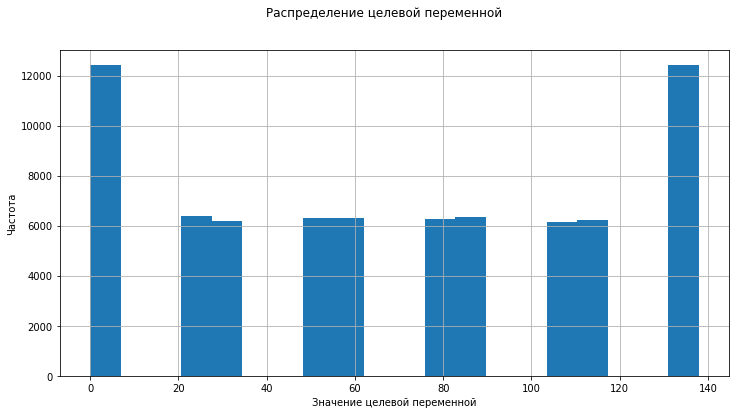

RMSE на валидационной выборке: 0.8902801001028846
Среднее значение предсказания: 68.7128780391376


In [14]:
result_1 = train_linear_regression(
    data=df_1,
    feature_columns=['f0', 'f1', 'f2'],
    target_column='product',
    test_size=0.25,
    random_state=42,
    n_iter=30,
    n_jobs=-1
)


In [15]:
features_valid_1 = result_1.get('features_valid')
features_train_1 = result_1.get('features_train')
target_valid_1 = result_1.get('target_valid')
target_train_1 = result_1.get('target_train')

### Модель для третьего региона

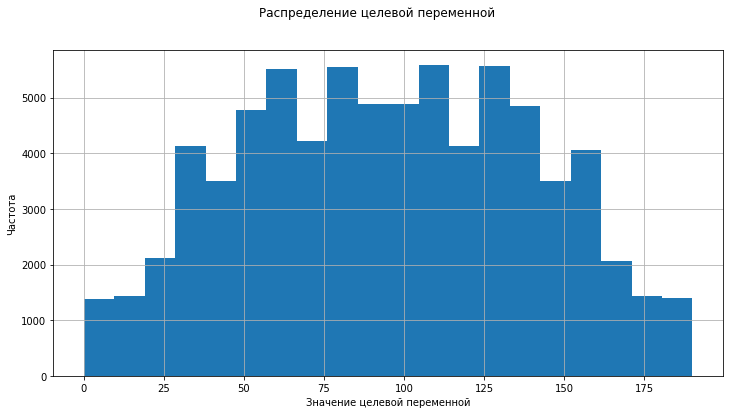

RMSE на валидационной выборке: 40.145872311342174
Среднее значение предсказания: 94.77102387765939


In [16]:
result_2 = train_linear_regression(
    data=df_2,
    feature_columns=['f0', 'f1', 'f2'],
    target_column='product',
    test_size=0.25,
    random_state=42,
    n_iter=30,
    n_jobs=-1
)


In [17]:
features_valid_2 = result_2.get('features_valid')
features_train_2 = result_2.get('features_train')
target_valid_2 = result_2.get('target_valid')
target_train_2 = result_2.get('target_train')

### Вывод:

Обучили модели для каждого региона и получили предсказания на валидационной выборке.\
**Первая модель:**
- RMSE на валидационной выборке: ***37.75660035026169***
- Среднее значение предсказания: ***92.39879990657768***


**Вторая модель:**
- RMSE на валидационной выборке: ***0.8902801001028846***
- Среднее значение предсказания: ***68.7128780391376***


**Третья модель:**
- RMSE на валидационной выборке: ***40.145872311342174***
- Среднее значение предсказания: ***94.77102387765939***



Лучший показатель RMSE оказался у модели для второго региона. При этом во втором регионе самый низкий показатель среднего количества сырья.

## Подготовка к расчёту прибыли

In [42]:
features_0 = df_0[['f0', 'f1', 'f2']]
target_0 = df_0['product']

In [43]:
linear_model_0 = LinearRegression()
linear_model_0.fit(features_train_0, target_train_0)

LinearRegression()

In [44]:
features_1 = df_1[['f0', 'f1', 'f2']]
target_1 = df_1['product']

In [45]:
linear_model_1 = LinearRegression()
linear_model_1.fit(features_train_1, target_train_1)

LinearRegression()

In [46]:
features_2 = df_2[['f0', 'f1', 'f2']]
target_2 = df_2['product']

In [47]:
linear_model_2 = LinearRegression()
linear_model_2.fit(features_train_2, target_train_2)

LinearRegression()

**Расчитаем безубыточную разработку сырья на 200 месторождениях**

In [48]:
average_profit_per_point = BUDGET / BEST_POINTS
print(f'Средняя прибыль на лучшую точку {average_profit_per_point}')

average_volume_oil = average_profit_per_point  / PRICE_BARREL
print(f'Средний объем нефти на точку {average_volume_oil}')

average_barrels = BUDGET / PRICE_BARREL
print(f'Средний объем нефти на регион {average_barrels}')

Средняя прибыль на лучшую точку 50000000.0
Средний объем нефти на точку 111.11111111111111
Средний объем нефти на регион 22222.222222222223


In [49]:
print(f'Средний запас нефти на скважину в первом регионе {df_0["product"].mean()}')
print(f'Средний запас нефти на скважину в первом регионе {df_1["product"].mean()}')
print(f'Средний запас нефти на скважину в первом регионе {df_2["product"].mean()}')

Средний запас нефти на скважину в первом регионе 92.50000000000001
Средний запас нефти на скважину в первом регионе 68.82500000000002
Средний запас нефти на скважину в первом регионе 95.00000000000004


**Создадим функцию для расчета прибыли на 500 разведанных точек**

In [50]:
def oil_profit(target, predictions, count):
    probs_sort = predictions.sort_values('product', ascending=False)
    select = target.loc[probs_sort.index][:count]
    return PRICE_BARREL * select.sum() - BUDGET

### Вывод:

- Создали переменные
- Рассчитали безубыточную выработку сырья для 200 месторождений и необходимый средний объем нефти
- Создали функцию для расчета прибыли\

И выяснили:\
Во втором регионе самый низкий средний запас нефти на скважину - 68.825\
В первом - 92.5\
В третьем - 95\
Средняя прибыль на лучшую точку 50000000.0\
Средний объем нефти на точку 111.11111111111111\
Средний объем нефти на регион 22222.222222222223

## Расчёт прибыли и рисков 

**Первый регион**

In [51]:
profits_0 = []
features, target, model = pd.concat([features_valid_0, features_train_0]), target_0, linear_model_0
for i in tqdm(range(BOOTSTRAP)):
    sample = features.sample(n=CHOSEN_POINTS, replace=True, random_state=RANDOM_STATE)
    predictions = pd.DataFrame(
        model.predict(sample),
        columns=['product'],
        index=sample.index)
    profits_0.append(oil_profit(
        target,
        predictions,
        BEST_POINTS)
    )

100%|██████████| 1000/1000 [00:01<00:00, 516.34it/s]


'Выборок с отрицательной прибылью: 43'

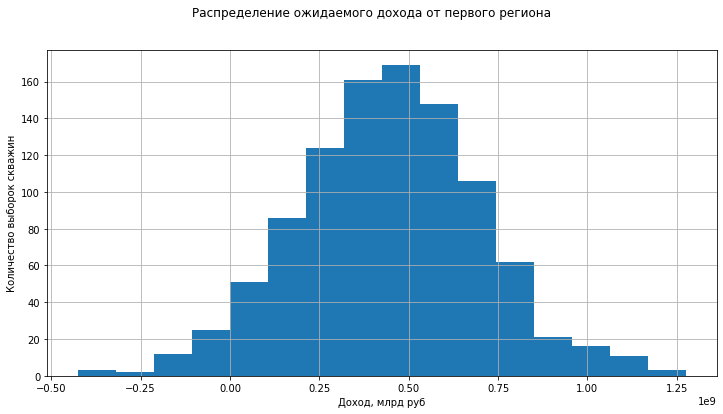

In [52]:
result0 = pd.Series(profits_0)
display(f'Выборок с отрицательной прибылью: {(result0 < 0).sum()}')

fig = plt.figure(figsize = (12, 6))
ax = fig.gca()
result_hist_0 = result0.hist(
    bins=16,
)
pl.suptitle('Распределение ожидаемого дохода от первого региона')
result_hist_0.set_xlabel('Доход, млрд руб')
result_hist_0.set_ylabel('Количество выборок скважин')
display()

**Найдем 95й доверительный интервал, риск убытков и среднюю прибыль**

In [53]:
linear_0_mean = result0.mean()
display(f'Средняя прибыль: {linear_0_mean: .10}  рублей')

'Средняя прибыль:  444776278.6  рублей'

In [54]:
print(f'Отрицательная прибыль: {(result0 < 0).mean(): .1%}')

Отрицательная прибыль:  4.3%


In [55]:
linear_0_min, linear_0_max = result0.quantile(.025), result0.quantile(.975)
print(f'95%-ый доверительный интервал: от {linear_0_min: .10}р. до {linear_0_max: .10}р.')

95%-ый доверительный интервал: от -71499518.51р. до  967298880.9р.


**Второй регион**

In [56]:
profits_1 = []
features, target, model = pd.concat([features_valid_1, features_train_1]), target_1, linear_model_1
for i in tqdm(range(BOOTSTRAP)):
    sample = features.sample(n=CHOSEN_POINTS, replace=True, random_state=RANDOM_STATE)
    predictions = pd.DataFrame(
        model.predict(sample),
        columns=['product'],
        index=sample.index)
    profits_1.append(oil_profit(
        target,
        predictions,
        BEST_POINTS)
    )

100%|██████████| 1000/1000 [00:01<00:00, 509.69it/s]


'Выборок с отрицательной прибылью: 20'

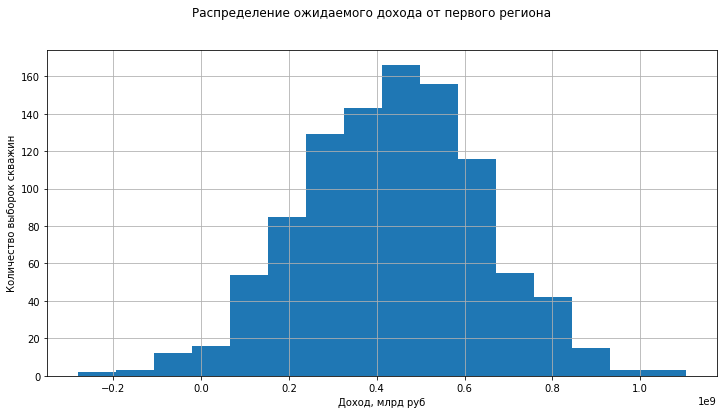

In [57]:
result1 = pd.Series(profits_1)
display(f'Выборок с отрицательной прибылью: {(result1 < 0).sum()}')

fig = plt.figure(figsize = (12, 6))
ax = fig.gca()
result_hist_1 = result1.hist(
    bins=16,
)
pl.suptitle('Распределение ожидаемого дохода от первого региона')
result_hist_1.set_xlabel('Доход, млрд руб')
result_hist_1.set_ylabel('Количество выборок скважин')
display()

In [58]:
linear_1_mean = result1.mean()
display(f'Средняя прибыль: {linear_1_mean: .10}  рублей')

'Средняя прибыль:  435717267.3  рублей'

In [59]:
print(f'Отрицательная прибыль: {(result1 < 0).mean(): .1%}')

Отрицательная прибыль:  2.0%


In [60]:
linear_1_min, linear_1_max = result1.quantile(.025), result1.quantile(.975)
print(f'95%-ый доверительный интервал: от {linear_1_min: .10}р. до {linear_1_max: .10}р.')

95%-ый доверительный интервал: от  13967877.65р. до  832304647.5р.


**Третий регион**

In [61]:
profits_2 = []
features, target, model = pd.concat([features_valid_2, features_train_2]), target_2, linear_model_2
for i in tqdm(range(BOOTSTRAP)):
    sample = features.sample(n=CHOSEN_POINTS, replace=True, random_state=RANDOM_STATE)
    predictions = pd.DataFrame(
        model.predict(sample),
        columns=['product'],
        index=sample.index)
    profits_2.append(oil_profit(
        target,
        predictions,
        BEST_POINTS)
    )

100%|██████████| 1000/1000 [00:01<00:00, 511.67it/s]


'Выборок с отрицательной прибылью: 73'

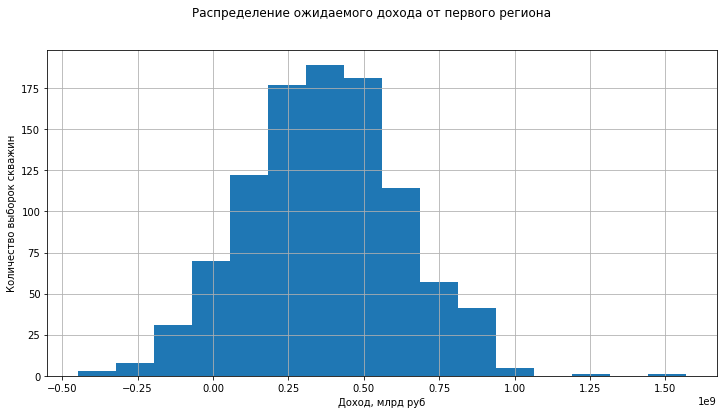

In [62]:
result2 = pd.Series(profits_2)
display(f'Выборок с отрицательной прибылью: {(result2 < 0).sum()}')

fig = plt.figure(figsize = (12, 6))
ax = fig.gca()
result_hist_2 = result2.hist(
    bins=16,
)
pl.suptitle('Распределение ожидаемого дохода от первого региона')
result_hist_2.set_xlabel('Доход, млрд руб')
result_hist_2.set_ylabel('Количество выборок скважин')
display()

In [63]:
linear_2_mean = result2.mean()
display(f'Средняя прибыль: {linear_2_mean: .10}  рублей')

'Средняя прибыль:  369511509.9  рублей'

In [64]:
print(f'Отрицательная прибыль: {(result2 < 0).mean(): .1%}')

Отрицательная прибыль:  7.3%


In [65]:
linear_2_min, linear_2_max = result2.quantile(.025), result2.quantile(.975)
print(f'95%-ый доверительный интервал: от {linear_2_min: .10}р. до {linear_2_max: .10}р.')

95%-ый доверительный интервал: от -110887061.8р. до  867717958.7р.


### Вывод:

Самым прибыльным регионом является второй - 464.5 млн руб и с вероятностью убытков 1.2%, поэтому самым перспективным будет второй регион

## Общий вывод
Мы исследовали  3 региона для разработки скважин по добыче нефти и для каждого региона была разработана модель. Были выполнены следующие шаги:
1. Загрузка и подготовка данных
2. Обучение и проверка моделей
3. Подготовка к расчету прибыли
4. Расчет прибыли и рисков\


На основании данных, предсказанных моделями, мы увидели преимущество ***второго региона***, а именно самый высокий показатель средней прибыли - **464.5 млн руб**, против **420.1 млн руб** у первого региона и **366.2 млн руб** у третьего, и самый низкий показатель отрицательной прибыли - **1.2%** против **4.8%** у первого региона и **7.8%** у третьего.
Самый убыточным будет третий регион.